# Task description:
- Modify the model so that it uses a 5x5 kernel
    - How does the number of free parameters in the model then change?
    - Does overfitting improve or worsen?
- Can you find an image which contains neither bird nor plane but is recognized by the network as one of the two objects with at least 95% probability?

# Implementation:

In [171]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import datetime
import random

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

Modify the model so that it uses a 5x5 kernel:

In [173]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [174]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [175]:
# define the two nets with the 3x3-Kernel and the new 5x5-Kernel
class Net_3x3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # padding=((kernel_size-1)/2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
class Net_5x5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2) # padding=((kernel_size-1)/2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [176]:
# define the training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs) 
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            loss_train += loss.item() 

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [177]:
# validates the accuracy of a given model on training and validation data 
# and stores the results in a dictionary
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [226]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

model = Net_3x3()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop( 
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["baseline"] = validate(model, train_loader, val_loader)
print("Number of free parameters in the model:",sum(p.numel() for p in model.parameters()))


2023-06-02 14:32:09.903340 Epoch 1, Training loss 0.5561399643967866
2023-06-02 14:32:37.878557 Epoch 10, Training loss 0.3278891425223867
2023-06-02 14:33:08.181482 Epoch 20, Training loss 0.2980692586891211
2023-06-02 14:33:38.423604 Epoch 30, Training loss 0.27329967327558313
2023-06-02 14:34:08.582947 Epoch 40, Training loss 0.25157777765753925
2023-06-02 14:34:37.937447 Epoch 50, Training loss 0.2348853757332085
2023-06-02 14:35:07.717835 Epoch 60, Training loss 0.21817942352811243
2023-06-02 14:35:37.768473 Epoch 70, Training loss 0.20425781916091396
2023-06-02 14:36:07.333368 Epoch 80, Training loss 0.1873378913825864
2023-06-02 14:36:37.168582 Epoch 90, Training loss 0.17626218412332473
2023-06-02 14:37:06.856186 Epoch 100, Training loss 0.16178494032211366
Accuracy train: 0.93
Accuracy val: 0.88
Number of free parameters in the model: 18090


In [227]:
model = Net_3x3()
model_name = "birds_vs_airplanes_3x3.pt"
data_path = "C:\\Users\\tvogt\\OneDrive\\Dokumente\\FH_Dortmund\\DeepLearning\\Convolution"

try:
    torch.save(model.state_dict(), data_path + model_name)
    print(f"Model {model_name} saved successfully")
except:
    print(f"Could not save model {model_name}")

Model birds_vs_airplanes_3x3.pt saved successfully


In [228]:
model = Net_5x5()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop( 
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["biggerKernel"] = validate(model, train_loader, val_loader)
print("Number of free parameters in the model:",sum(p.numel() for p in model.parameters()))

2023-06-02 14:37:12.150060 Epoch 1, Training loss 0.5788736487649808
2023-06-02 14:37:41.463631 Epoch 10, Training loss 0.3241153276839833
2023-06-02 14:38:13.765281 Epoch 20, Training loss 0.27539890933378486
2023-06-02 14:38:45.899309 Epoch 30, Training loss 0.24614613655076664
2023-06-02 14:39:18.556972 Epoch 40, Training loss 0.22555985259022682
2023-06-02 14:39:51.126868 Epoch 50, Training loss 0.20024050928794654
2023-06-02 14:40:24.334094 Epoch 60, Training loss 0.18119362812892648
2023-06-02 14:40:57.681875 Epoch 70, Training loss 0.16361402682248194
2023-06-02 14:41:31.370781 Epoch 80, Training loss 0.1440925090603388
2023-06-02 14:42:04.681694 Epoch 90, Training loss 0.12633091545883257
2023-06-02 14:42:37.306479 Epoch 100, Training loss 0.10816271075160261
Accuracy train: 0.93
Accuracy val: 0.89
Number of free parameters in the model: 20906


### Answer:
- How does the number of free parameters in the model then change?
    - The number of free parameters increases from 18090 for the 3x3-Kernel to 20906 free parameters for the 5x5-Kernel. <br>
    The number of parameters in a convolutional layer is determined by the kernel size, input channels, and output channels. By increasing the kernel size the number of parameters in the model will generally increase, so the answer was to be expected.
- Does overfitting improve or worsen?
    - Increasing the kernel size to 5x5 may increase the risk of overfitting. A larger kernel size allows the model to capture more complex patterns in the data, which can potentially lead to better performance on the training set. However, if the model becomes too complex or over-parameterized, it may start to memorize the training data and struggle to generalize well to unseen data, resulting in overfitting. Therefore, it is possible that overfitting worsens when using a larger kernel size. <br>
    In reality, I could not clearly detect any overfitting. The accuracy for the training data set is slightly higher for both kernel sizes than for the validation data set. However, there is not much difference between the two training (about 0.93) and validation (about 0.89) accuracies.


In [229]:
# save the model
model = Net_5x5()
model_name = "birds_vs_airplanes_5x5.pt"
data_path = "C:\\Users\\tvogt\\OneDrive\\Dokumente\\FH_Dortmund\\DeepLearning\\Convolution"

try:
    torch.save(model.state_dict(), data_path + model_name)
    print(f"Model {model_name} saved successfully")
except:
    print(f"Could not save model {model_name}")

Model birds_vs_airplanes_5x5.pt saved successfully


Can you find an image which contains neither bird nor plane but is recognized by the network as one of the two objects with at least 95% probability?

In [230]:
# load dataset with images and labels from the cifar10 with all but the two classes bird and airplane
data_path = '../data-unversioned/p1ch6/'
cifar10_nonor = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))
cifar10_val_nonor = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))


label_map_not = {1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7}
class_names_not = ['automobile', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifarnot2 = [(img, label_map_not[label])
          for img, label in cifar10_nonor
          if label in [1, 3, 4, 5, 6, 7, 8, 9]]

cifarnot2_val = [(img, label_map_not[label])
              for img, label in cifar10_val_nonor
              if label in [1, 3, 4, 5, 6, 7, 8, 9]]


Files already downloaded and verified
Files already downloaded and verified


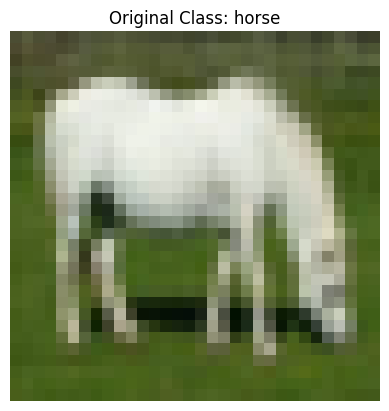

In [255]:
# randomly choosing an image from the unknown dataset
img_not, label_not = random.choice(cifarnot2)

# show the choosen image with the correct label
plt.imshow(img_not.permute(1,2,0))
plt.title(f"Original Class: {class_names_not[label_not]}")
plt.axis('off')
plt.show()


In [256]:
# load model with 3x3 - Kernel
loaded_model = Net_3x3()  # <1>
try:
    loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))
    print("Model was loaded successfully")
except:
    print("Model could not be loaded")

Model was loaded successfully


In [257]:
# computes the softmax activation function for a given input tensor x, 
# which exponentiates each element of x, divides it by the sum of the exponentiated elements,
# and returns the resulting tensor
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [258]:
# let the model run with the choosen image and calculate the probabilities for it being a bird or an airplane
out = loaded_model(img_not)
probability = softmax(out)[0]
probability_airplane = round(probability[0].item(),4)
probability_bird = round(probability[1].item(),4)

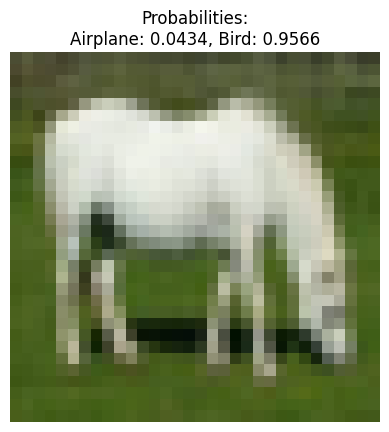

In [259]:
# show the choosen image with the calculated label probabilities
plt.imshow(img_not.permute(1,2,0))
plt.title(f"Probabilities:\nAirplane: {probability_airplane}, Bird: {probability_bird}")
plt.axis('off')
plt.show()